In [1]:
from models.cnp import CNP
from models.wta_cnp import WTA_CNP
from models.common import *

from data.data_generators import *
import torch


def get_available_gpu_with_most_memory():
    gpu_memory = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch to the GPU to accurately measure memory
        gpu_memory.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
    
    gpu_memory.sort(key=lambda x: x[1], reverse=True)
    
    return gpu_memory[0][0]

if torch.cuda.is_available():
    available_gpu = get_available_gpu_with_most_memory()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device:", device)

###

torch.set_float32_matmul_precision('high')

Device WTA: cuda:0 Device CNP: cuda:0


In [2]:
batch_size = 2
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 2
num_classes = 2
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 2
num_val_indiv = num_val//num_classes

colors = ['tomato', 'aqua', 'limegreen', 'gold']

X: torch.Size([1, 200, 1]) Y: torch.Size([1, 200, 1]) VX: torch.Size([1, 200, 1]) VY: torch.Size([1, 200, 1])


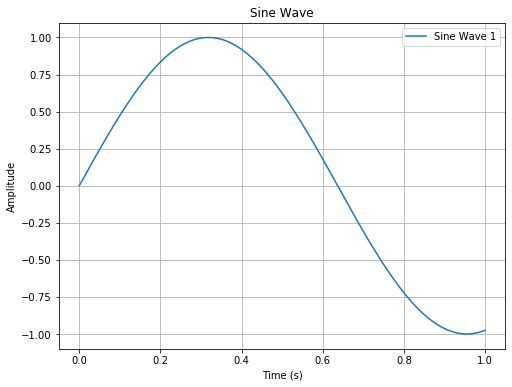

In [3]:
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
# dum_x = torch.linspace(0, 1, 220).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

for i in range(num_classes):
    start_ind = i*num_indiv
    coeff = (i+1)/2*torch.pi
    y[start_ind:start_ind+num_indiv] = torch.unsqueeze(generate_sin(x*coeff), 2)

    noise = torch.unsqueeze(torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip, -1)

    start_ind = i*num_val_indiv
    vy[start_ind:start_ind+num_indiv] = y[start_ind:start_ind+num_indiv].clone() + noise  # num_indiv = num_val_indiv

# coeff = 2*torch.pi
# y[:num_indiv] = torch.unsqueeze(generate_sin(x*coeff), 2)
# coeff = torch.pi
# y[num_indiv:] = torch.unsqueeze(generate_sin(x*coeff), 2)

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(num_demos):
    plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), label=f'Sine Wave {i+1}')
    # plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)

plt.legend()
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Sine Wave')

x, y = x.to(device), y.to(device)
vx, vy = vx.to(device), vy.to(device)

In [5]:
model_wta = WTA_CNP(1, 1, n_max_obs, n_max_tar, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[125, 125], batch_size=batch_size, scale_coefs=True).to(device)
optimizer_wta = torch.optim.Adam(lr=1e-4, params=model_wta.parameters())

model_cnp = CNP(input_dim=1, hidden_dim=128, output_dim=1, n_max_obs=n_max_obs, n_max_tar=n_max_tar, num_layers=3, batch_size=batch_size).to(device)
optimizer_cnp = torch.optim.Adam(lr=1e-4, params=model_cnp.parameters())

# print("WTA Model:", model_wta)

In [ ]:
data = DataOps(x, y, vx, vy, batch_size, n_max_obs, n_max_tar, device)

In [6]:
def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("WTA-CNP:", get_parameter_count(model_wta))
print("CNP:", get_parameter_count(model_cnp))

if torch.__version__ >= "2.0":
    model_cnp, model_wta = torch.compile(model_cnp), torch.compile(model_wta)

WTA-CNP: 66670
CNP: 66818


In [8]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/sine/1_sine/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 500_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss_wta, avg_loss_cnp = 0, 0

print_loss_per_epoch = 100
val_per_epoch = 1000
min_val_loss_wta, min_val_loss_cnp = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

training_loss_wta, validation_error_wta = [], []
training_loss_cnp, validation_error_cnp = [], []

wta_tr_loss_path = f'{root_folder}wta_training_loss.pt'
wta_val_err_path = f'{root_folder}wta_validation_error.pt'
cnp_tr_loss_path = f'{root_folder}cnp_training_loss.pt'
cnp_val_err_path = f'{root_folder}cnp_validation_error.pt'

for epoch in range(epochs):
    epoch_loss_wta, epoch_loss_cnp = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer_wta.zero_grad()
        optimizer_cnp.zero_grad()

        obs_wta, tar_x_wta, tar_y_wta, obs_mask_wta, tar_mask_wta = data.get_batch(traj_ids[i])
        obs_cnp, tar_x_cnp, tar_y_cnp, obs_mask_cnp, tar_mask_cnp = obs_wta, tar_x_wta, tar_y_wta, obs_mask_wta, tar_mask_wta

        pred_wta, gate_wta = model_wta(obs_wta, tar_x_wta, obs_mask_wta)
        pred_cnp, encoded_rep_cnp = model_cnp(obs_cnp, tar_x_cnp)

        loss_wta, wta_nll = model_wta.loss(pred_wta, gate_wta, tar_y_wta, tar_mask_wta)

        loss_wta.backward()
        optimizer_wta.step()

        loss_cnp = model_cnp.loss(pred_cnp, tar_y_cnp)
        loss_cnp.backward()
        optimizer_cnp.step()

        epoch_loss_wta += wta_nll.item()
        epoch_loss_cnp += loss_cnp.item()

    training_loss_wta.append(epoch_loss_wta)
    training_loss_cnp.append(epoch_loss_cnp)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss_wta, val_loss_cnp = 0, 0

            for j in range(v_epoch_iter):
                o_wta, t_wta, tr_wta = data.get_validation_batch(vx, vy, v_traj_ids[j], n_max_obs, device)
                o_cnp, t_cnp, tr_cnp = o_wta, t_wta, tr_wta

                p_wta, g_wta = model_wta(o_wta, t_wta)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss_wta += mse_loss(vp_means, tr_wta).item()

                pred_cnp, encoded_rep = model_cnp(o_cnp, t_cnp)
                val_loss_cnp += mse_loss(pred_cnp[:, :, :model_cnp.output_dim], tr_cnp)

            validation_error_wta.append(val_loss_wta)
            if val_loss_wta < min_val_loss_wta:
                min_val_loss_wta = val_loss_wta
                print(f'(WTA)New best: {min_val_loss_wta}')
                torch.save(model_wta.state_dict(), f'{root_folder}saved_models/wta_on_synth.pt')

            validation_error_cnp.append(val_loss_cnp.item())
            if val_loss_cnp < min_val_loss_cnp:
                min_val_loss_cnp = val_loss_cnp
                print(f'(CNP)New best: {min_val_loss_cnp}')
                torch.save(model_cnp.state_dict(), f'{root_folder}saved_models/cnp_on_synth.pt')
  
        if epoch % (val_per_epoch*10) == 0:
            draw_val_plot(root_folder, epoch, x, y, vy, model_cnp, model_wta, device, batch_size, colors)


    avg_loss_wta += epoch_loss_wta
    avg_loss_cnp += epoch_loss_cnp

    if epoch % print_loss_per_epoch == 0:
        print("Epoch: {}, WTA-Loss: {}, CNP-Loss: {}".format(epoch, avg_loss_wta/print_loss_per_epoch, avg_loss_cnp/print_loss_per_epoch))
        avg_loss_wta, avg_loss_cnp = 0, 0

torch.save(torch.Tensor(training_loss_wta), wta_tr_loss_path)
torch.save(torch.Tensor(validation_error_wta), wta_val_err_path)
torch.save(torch.Tensor(training_loss_cnp), cnp_tr_loss_path)
torch.save(torch.Tensor(validation_error_cnp), cnp_val_err_path)

(WTA)New best: 0.5522716641426086
(CNP)New best: 0.5489335656166077
Epoch: 0, WTA-Loss: 0.001382223129272461, CNP-Loss: 0.0013512246608734131


[2023-09-20 17:10:33,902] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/home/yigit/projects/mbcnp/models/wta_cnp.py:64)
   reasons:  tensor 'obs' strides mismatch at index 0. expected 10, actual 4
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.
[2023-09-20 17:10:34,367] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/home/yigit/projects/mbcnp/models/cnp.py:35)
   reasons:  tensor 'obs' strides mismatch at index 0. expected 10, actual 4
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.


(WTA)New best: 0.38384056091308594
(CNP)New best: 0.23329737782478333
Epoch: 1000, WTA-Loss: 1.0115120073854924, CNP-Loss: 0.9549467703104019
(WTA)New best: 0.24857504665851593
(CNP)New best: 0.056740652769804
Epoch: 2000, WTA-Loss: 0.8187729261517525, CNP-Loss: 0.28388366267294624
(WTA)New best: 0.16155488789081573
(CNP)New best: 0.05578776076436043
Epoch: 3000, WTA-Loss: 0.6046122130006552, CNP-Loss: -0.14427780097688084
(WTA)New best: 0.11644266545772552
(CNP)New best: 0.04096854478120804
Epoch: 4000, WTA-Loss: 0.45928550395555795, CNP-Loss: -0.29406963915316736
(WTA)New best: 0.08986885100603104
(CNP)New best: 0.030750762671232224
Epoch: 5000, WTA-Loss: 0.26514908024619943, CNP-Loss: -0.395450466276292
(WTA)New best: 0.07500512152910233
(CNP)New best: 0.02228323556482792
Epoch: 6000, WTA-Loss: 0.06965183100174181, CNP-Loss: -0.5987518230924616
(WTA)New best: 0.06288593262434006
(CNP)New best: 0.014046505093574524
Epoch: 7000, WTA-Loss: -0.09359752554877196, CNP-Loss: -0.77889023684

In [9]:
open(f'{root_folder}fin', 'w').close()